In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
from scipy.stats import pearsonr
import matplotlib
from tqdm import tqdm
from typing import List, Dict
import calpgs
import glob
from natsort import natsorted
import tempfile
import subprocess
from typing import Dict
import itertools
import submitit
from scipy import stats

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

# Calibrated at all levels of prediction std?

In [2]:
def plot_predstd(trait, indiv_group, ax):
    df_data = {"expected": [], "observed": []}
    for i in range(1, 21):
        # read data
        prefix = f"out/model/{trait}-{indiv_group}/{i}-mean+var+slope"

        df_predint = pd.read_csv(f"{prefix}.test_info.tsv", sep="\t", index_col=0)
        df_params = pd.read_csv(f"{prefix}.param.tsv", sep="\t", index_col=0)

        df_tmp = df_predint.copy()
        df_tmp["cal_predstd_q"] = pd.qcut(df_tmp["cal_predstd"], q=10).cat.codes

        a = df_tmp.groupby("cal_predstd_q").apply(lambda df: np.mean(df["cal_predstd"]))
        b = df_tmp.groupby("cal_predstd_q").apply(
            lambda df: np.sqrt(np.mean((df["cal_pred"] - df["pheno"]) ** 2))
        )
        df_data["expected"].extend(a)
        df_data["observed"].extend(b)
    df_data = pd.DataFrame(df_data)

    a = df_data["expected"].values
    b = df_data["observed"].values
    linreg = stats.linregress(x=a, y=b)
    print(f"obs = {linreg.slope:.2g} * expect + {linreg.intercept:.2g}")
    ax.scatter(a, b, s=4)
    ax.axline((a[0], a[0]), slope=1, color="black", ls="--")
    ax.set_xlabel("Expected standard deviation")
    ax.set_ylabel("Observed standard deviation")
    ax.set_aspect("equal")

    trait_name = {"height": "Height", "LDL": "LDL"}[trait]
    group_name = {"white": "WB", "other": "Diverse"}[indiv_group]
    ax.set_title(f"{trait_name} in {group_name} populations", fontsize=11)

obs = 0.92 * expect + 0.068
obs = 0.91 * expect + 0.47


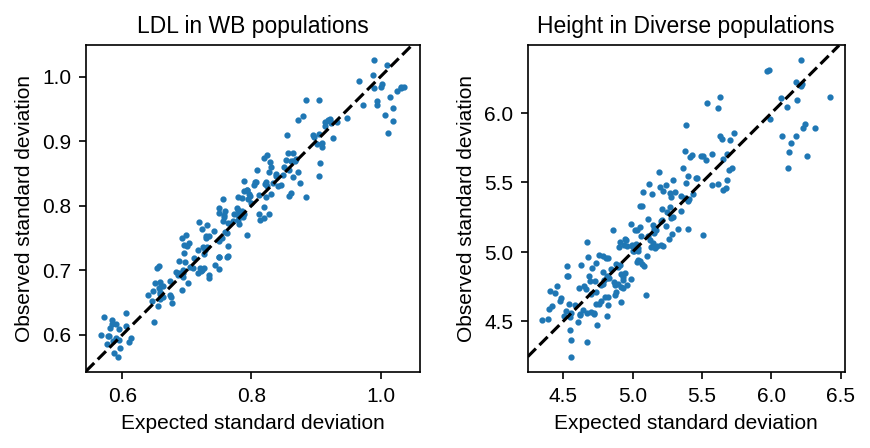

In [3]:
fig, axes = plt.subplots(figsize=(6, 3), dpi=150, ncols=2)
plot_predstd(trait="LDL", indiv_group="white", ax=axes[0])
plot_predstd(trait="height", indiv_group="other", ax=axes[1])
fig.tight_layout()
plt.savefig("results/supp-predstd-calibration.pdf", bbox_inches="tight")

# Calibration at each strata of the data

In [4]:
def plot_coverage(trait, indiv_group, ax, n_q=10, stratify_by="PGS"):
    ci_z = stats.norm.ppf((1 + 0.9) / 2)
    df_data = {"q": [], "coverage": []}
    for i in range(1, 21):
        # read data
        prefix = f"out/model/{trait}-{indiv_group}/{i}-mean+var+slope"

        df_predint = pd.read_csv(f"{prefix}.test_info.tsv", sep="\t", index_col=0)
        df_params = pd.read_csv(f"{prefix}.param.tsv", sep="\t", index_col=0)

        df_tmp = df_predint.copy()
        df_tmp["covar_q"] = pd.qcut(df_tmp[stratify_by], q=n_q).cat.codes
        coverage = df_tmp.groupby("covar_q").apply(
            lambda df: np.mean(
                np.abs(df["cal_pred"] - df["pheno"]) < df["cal_predstd"] * ci_z
            )
        )
        df_data["coverage"].extend(coverage)
        df_data["q"].extend(np.arange(1, n_q + 1))
    df_data = pd.DataFrame(df_data)
    mean_sem = df_data.groupby("q").agg(["mean", "sem"])["coverage"]

    ax.scatter(df_data["q"] - 0.1, df_data["coverage"], s=2, alpha=0.3, color="black")
    ax.errorbar(
        x=np.arange(1, n_q + 1) + 0.1,
        y=mean_sem["mean"],
        yerr=mean_sem["sem"] * 1.96,
        fmt=".",
        capsize=3,
    )

    ax.set_ylim(0.825, 0.975)
    ax.axhline(y=0.9, color="red", ls="--", zorder=-10)
    ax.set_xticks(np.arange(1, n_q + 1))
    ax.set_ylabel("Coverage")
    ax.set_xlabel("PGS decile")
    trait_name = {"height": "Height", "LDL": "LDL"}[trait]
    group_name = {"white": "WB", "other": "Diverse"}[indiv_group]
    ax.set_title(f"{trait_name} in {group_name} populations", fontsize=11)

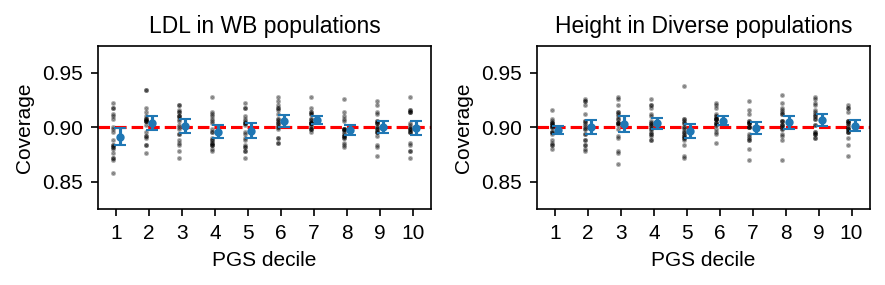

In [5]:
fig, axes = plt.subplots(figsize=(6, 2), dpi=150, ncols=2)
plot_coverage(trait="LDL", indiv_group="white", ax=axes[0])
plot_coverage(trait="height", indiv_group="other", ax=axes[1])
fig.tight_layout()
plt.savefig("results/supp-coverage-calibration.pdf", bbox_inches="tight")

# Differences across different fitting strategies ($R^2$, calibration)

In [6]:
def plot_r2(trait, indiv_group):
    df_data = {"method": [], "seed": [], "pheno": [], "pred": [], "predstd": []}
    for i in range(1, 21):
        for suffix in ["mean+var+slope", "mean+var"]:
            # read data
            prefix = f"out/model/{trait}-{indiv_group}/{i}-{suffix}"
            df_predint = pd.read_csv(f"{prefix}.test_info.tsv", sep="\t", index_col=0)
            df_data["pheno"].extend(df_predint["pheno"])
            df_data["pred"].extend(df_predint["cal_pred"])
            df_data["predstd"].extend(df_predint["cal_predstd"])
            df_data["seed"].extend([i] * len(df_predint))
            df_data["method"].extend([suffix] * len(df_predint))

    df_data = pd.DataFrame(df_data)
    mean_sem = (
        df_data.groupby(["method", "seed"])
        .apply(lambda df: stats.pearsonr(df["pred"], df["pheno"])[0] ** 2)
        .groupby("method")
        .agg(["mean", "sem"])
    )
    display(mean_sem)

In [7]:
for trait in ["height", "LDL"]:
    for group in ["white", "other"]:
        plot_r2(trait=trait, indiv_group=group)

,mean,sem
method,,
mean+var,0.713939,0.001423
mean+var+slope,0.713888,0.001392


,mean,sem
method,,
mean+var,0.688325,0.001404
mean+var+slope,0.690071,0.001407


,mean,sem
method,,
mean+var,0.109880,0.001748
mean+var+slope,0.166712,0.001956


,mean,sem
method,,
mean+var,0.107597,0.001884
mean+var+slope,0.162578,0.002368
